### Load required libraries

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [58]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [59]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [60]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [61]:
df.isnull().values.any()

False

In [62]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [63]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(10000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [64]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [65]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [66]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(10000)

dfd = x1.append(x2)
x = dfd.drop(['Class'], axis=1)
y = dfd['Class'].values

SEED = 42

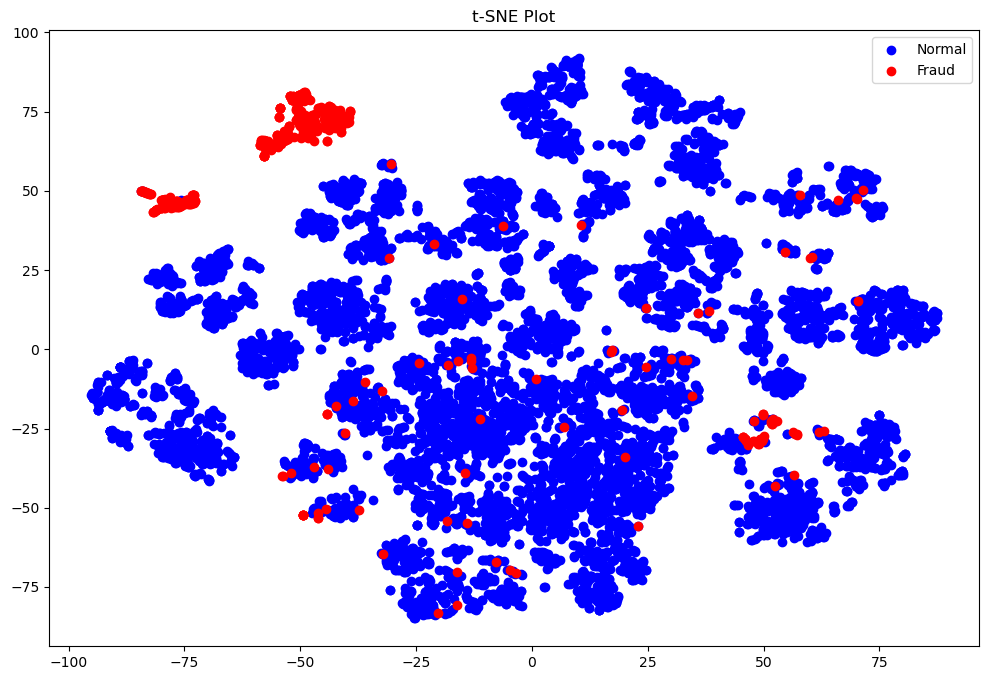

In [67]:
tsne = TSNE(n_components=2, random_state=SEED, init='random', learning_rate=200)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

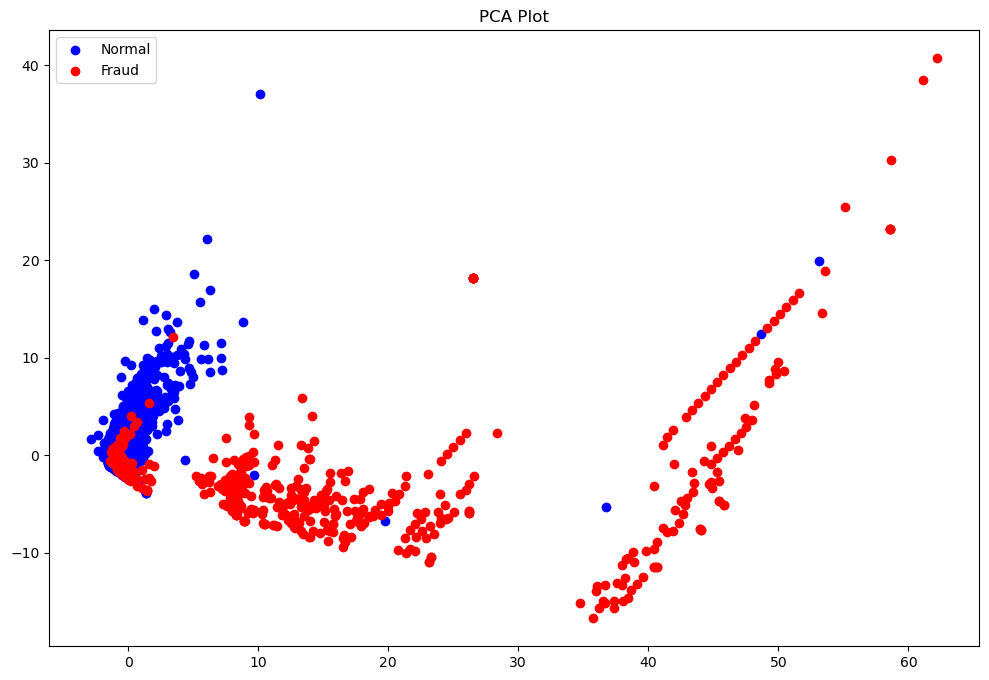

In [68]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [69]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### Sparse AutoEncoder Model(L1)

In [70]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(40, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(56, activation="elu",activity_regularizer=regularizers.l1(10e-5))(encoder)

decoder = Dense(40, activation='elu',activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(input_dim, activation='elu')(decoder)
sae_L1 = Model(inputs=input_layer, outputs=decoder)

In [71]:
epochs = 100
batch_size = 32
sae_L1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="fraudSpAE_L1.pth", verbose=0, save_best_only=True)

### Training

In [72]:
history = sae_L1.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/100
5598/5598 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.8856INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.2947 - accuracy: 0.8856 - val_loss: 0.2429 - val_accuracy: 0.9062
Epoch 2/100
5582/5598 [============================>.] - ETA: 0s - loss: 0.2635 - accuracy: 0.9186INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2634 - accuracy: 0.9186 - val_loss: 0.2366 - val_accuracy: 0.9241
Epoch 3/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.9196INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.2605 - accuracy: 0.9196 - val_loss: 0.2355 - val_accuracy: 0.9212
Epoch 4/100
5583/5598 [============================>.] - ETA: 0s - loss: 0.2564 - accuracy: 0.9187INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.2561 - accuracy: 0.9187 - val_loss: 0.2333 - val_accuracy: 0.9231
Epoch 5/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.2542 - accuracy: 0.9194INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 22s 4ms/step - loss: 0.2542 - accuracy: 0.9195 - val_loss: 0.2283 - val_accuracy: 0.9289
Epoch 6/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2526 - accuracy: 0.9195 - val_loss: 0.2300 - val_accuracy: 0.9278
Epoch 7/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2507 - accuracy: 0.9210 - val_loss: 0.2301 - val_accuracy: 0.9184
Epoch 8/100
5578/5598 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.9198INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2506 - accuracy: 0.9199 - val_loss: 0.2253 - val_accuracy: 0.9266
Epoch 9/100
5583/5598 [============================>.] - ETA: 0s - loss: 0.2498 - accuracy: 0.9194INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 0.2496 - accuracy: 0.9194 - val_loss: 0.2246 - val_accuracy: 0.9359
Epoch 10/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.9226INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2489 - accuracy: 0.9226 - val_loss: 0.2242 - val_accuracy: 0.9330
Epoch 11/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2484 - accuracy: 0.9222 - val_loss: 0.2253 - val_accuracy: 0.9283
Epoch 12/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.2482 - accuracy: 0.9248INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2482 - accuracy: 0.9248 - val_loss: 0.2233 - val_accuracy: 0.9359
Epoch 13/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2477 - accuracy: 0.9256 - val_loss: 0.2263 - val_accuracy: 0.9293
Epoch 14/100
5582/5598 [============================>.] - ETA: 0s - loss: 0.2473 - accuracy: 0.9282INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 0.2472 - accuracy: 0.9283 - val_loss: 0.2227 - val_accuracy: 0.9380
Epoch 15/100
5578/5598 [============================>.] - ETA: 0s - loss: 0.2471 - accuracy: 0.9286INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2470 - accuracy: 0.9286 - val_loss: 0.2217 - val_accuracy: 0.9386
Epoch 16/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2470 - accuracy: 0.9282 - val_loss: 0.2226 - val_accuracy: 0.9393
Epoch 17/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2462 - accuracy: 0.9298 - val_loss: 0.2217 - val_accuracy: 0.9356
Epoch 18/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2459 - accuracy: 0.9310 - val_loss: 0.2326 - val_accuracy: 0.9036
Epoch 19/100
5579/5598 [============================>.] - ETA: 0s - loss: 0.2457 - accuracy: 0.9306INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2455 - accuracy: 0.9306 - val_loss: 0.2204 - val_accuracy: 0.9433
Epoch 20/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.2459 - accuracy: 0.9303INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2458 - accuracy: 0.9304 - val_loss: 0.2202 - val_accuracy: 0.9475
Epoch 21/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.2454 - accuracy: 0.9312 - val_loss: 0.2277 - val_accuracy: 0.9247
Epoch 22/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2452 - accuracy: 0.9309 - val_loss: 0.2208 - val_accuracy: 0.9411
Epoch 23/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.2450 - accuracy: 0.9335 - val_loss: 0.2234 - val_accuracy: 0.9327
Epoch 24/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.2446 - accuracy: 0.9352 - val_loss: 0.2205 - val_accuracy: 0.9452
Epoch 25/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2446 - accuracy: 0.9355 - val_loss: 0.2238 - val_accuracy: 0.9273
Epoch 26/100
5589/5598 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.9358INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.2444 - accuracy: 0.9359 - val_loss: 0.2199 - val_accuracy: 0.9403
Epoch 27/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.2442 - accuracy: 0.9353 - val_loss: 0.2228 - val_accuracy: 0.9382
Epoch 28/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2443 - accuracy: 0.9356 - val_loss: 0.2250 - val_accuracy: 0.9267
Epoch 29/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.2447 - accuracy: 0.9342INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2447 - accuracy: 0.9342 - val_loss: 0.2195 - val_accuracy: 0.9443
Epoch 30/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2442 - accuracy: 0.9357 - val_loss: 0.2204 - val_accuracy: 0.9492
Epoch 31/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2444 - accuracy: 0.9376 - val_loss: 0.2200 - val_accuracy: 0.9439
Epoch 32/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.9381INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.2442 - accuracy: 0.9382 - val_loss: 0.2192 - val_accuracy: 0.9494
Epoch 33/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2434 - accuracy: 0.9399 - val_loss: 0.2215 - val_accuracy: 0.9382
Epoch 34/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2439 - accuracy: 0.9395 - val_loss: 0.2197 - val_accuracy: 0.9480
Epoch 35/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2433 - accuracy: 0.9404 - val_loss: 0.2192 - val_accuracy: 0.9460
Epoch 36/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2432 - accuracy: 0.9399 - val_loss: 0.2196 - val_accuracy: 0.9472
Epoch 37/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.2434 - accuracy: 0.9416INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2434 - accuracy: 0.9416 - val_loss: 0.2191 - val_accuracy: 0.9385
Epoch 38/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2434 - accuracy: 0.9424 - val_loss: 0.2203 - val_accuracy: 0.9482
Epoch 39/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2431 - accuracy: 0.9429 - val_loss: 0.2199 - val_accuracy: 0.9440
Epoch 40/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2434 - accuracy: 0.9415 - val_loss: 0.2210 - val_accuracy: 0.9415
Epoch 41/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.2428 - accuracy: 0.9443 - val_loss: 0.2195 - val_accuracy: 0.9466
Epoch 42/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.2424 - accuracy: 0.9440INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2424 - accuracy: 0.9440 - val_loss: 0.2185 - val_accuracy: 0.9457
Epoch 43/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2420 - accuracy: 0.9446 - val_loss: 0.2189 - val_accuracy: 0.9445
Epoch 44/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2428 - accuracy: 0.9427 - val_loss: 0.2192 - val_accuracy: 0.9493
Epoch 45/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2423 - accuracy: 0.9447 - val_loss: 0.2188 - val_accuracy: 0.9492
Epoch 46/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.2425 - accuracy: 0.9452INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 0.2424 - accuracy: 0.9452 - val_loss: 0.2183 - val_accuracy: 0.9443
Epoch 47/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2423 - accuracy: 0.9434 - val_loss: 0.2187 - val_accuracy: 0.9533
Epoch 48/100
5572/5598 [============================>.] - ETA: 0s - loss: 0.2424 - accuracy: 0.9445INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 0.2420 - accuracy: 0.9444 - val_loss: 0.2179 - val_accuracy: 0.9546
Epoch 49/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2421 - accuracy: 0.9448 - val_loss: 0.2184 - val_accuracy: 0.9475
Epoch 50/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2422 - accuracy: 0.9450 - val_loss: 0.2206 - val_accuracy: 0.9326
Epoch 51/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2422 - accuracy: 0.9453 - val_loss: 0.2188 - val_accuracy: 0.9511
Epoch 52/100
5583/5598 [============================>.] - ETA: 0s - loss: 0.2422 - accuracy: 0.9439INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 0.2421 - accuracy: 0.9440 - val_loss: 0.2178 - val_accuracy: 0.9527
Epoch 53/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2420 - accuracy: 0.9441 - val_loss: 0.2225 - val_accuracy: 0.9409
Epoch 54/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2418 - accuracy: 0.9459 - val_loss: 0.2220 - val_accuracy: 0.9179
Epoch 55/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2420 - accuracy: 0.9450 - val_loss: 0.2180 - val_accuracy: 0.9550
Epoch 56/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2416 - accuracy: 0.9452 - val_loss: 0.2194 - val_accuracy: 0.9441
Epoch 57/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.2419 - accuracy: 0.9448INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 0.2419 - accuracy: 0.9448 - val_loss: 0.2175 - val_accuracy: 0.9585
Epoch 58/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2416 - accuracy: 0.9460 - val_loss: 0.2181 - val_accuracy: 0.9567
Epoch 59/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2420 - accuracy: 0.9453 - val_loss: 0.2176 - val_accuracy: 0.9580
Epoch 60/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2415 - accuracy: 0.9457 - val_loss: 0.2177 - val_accuracy: 0.9486
Epoch 61/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2415 - accuracy: 0.9459 - val_loss: 0.2176 - val_accuracy: 0.9560
Epoch 62/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2417 - accuracy: 0.9461 - val_loss: 0.2178 - val_accuracy: 0.9523
Epoch 63/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2420 - accuracy: 0.9458 - val_loss: 0.2200 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.2414 - accuracy: 0.9468 - val_loss: 0.2171 - val_accuracy: 0.9537
Epoch 85/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2414 - accuracy: 0.9486 - val_loss: 0.2186 - val_accuracy: 0.9495
Epoch 86/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2420 - accuracy: 0.9471 - val_loss: 0.2178 - val_accuracy: 0.9496
Epoch 87/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2413 - accuracy: 0.9496 - val_loss: 0.2177 - val_accuracy: 0.9536
Epoch 88/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2417 - accuracy: 0.9468 - val_loss: 0.2203 - val_accuracy: 0.9409
Epoch 89/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2411 - accuracy: 0.9491 - val_loss: 0.2172 - val_accuracy: 0.9491
Epoch 90/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.2414 - accuracy: 0.9480 - val_loss: 0.2193 - val_a

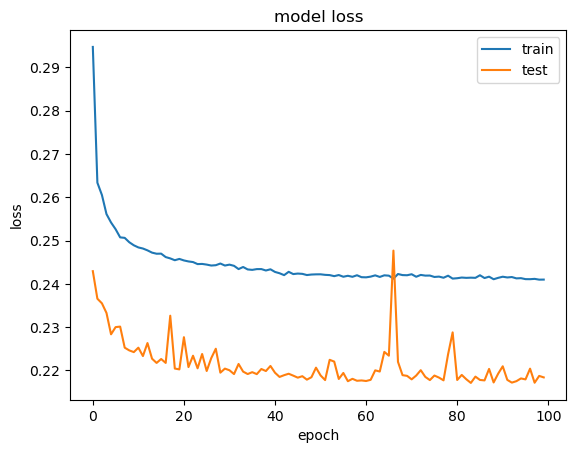

In [73]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [74]:
sae_L1 = load_model('fraudSpAE_L1.pth')

In [75]:
predictions = sae_L1.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2671/2671 [==============================] - 6s 2ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.257715,0.00165
std,2.905609,0.04059
min,0.000284,0.00000
25%,0.005430,0.00000
50%,0.028837,0.00000
75%,0.093246,0.00000
max,339.182301,1.00000


In [76]:
threshold = 2.9

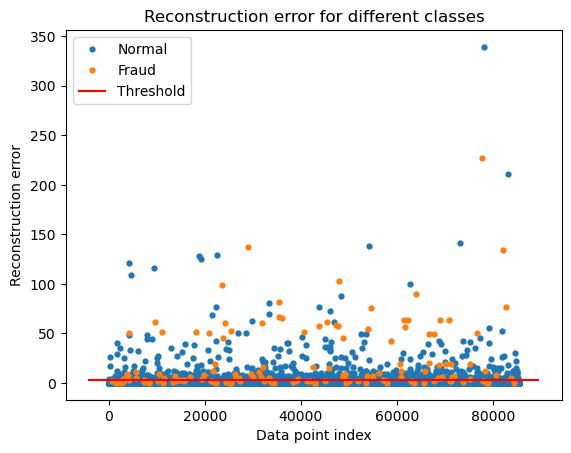

In [77]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

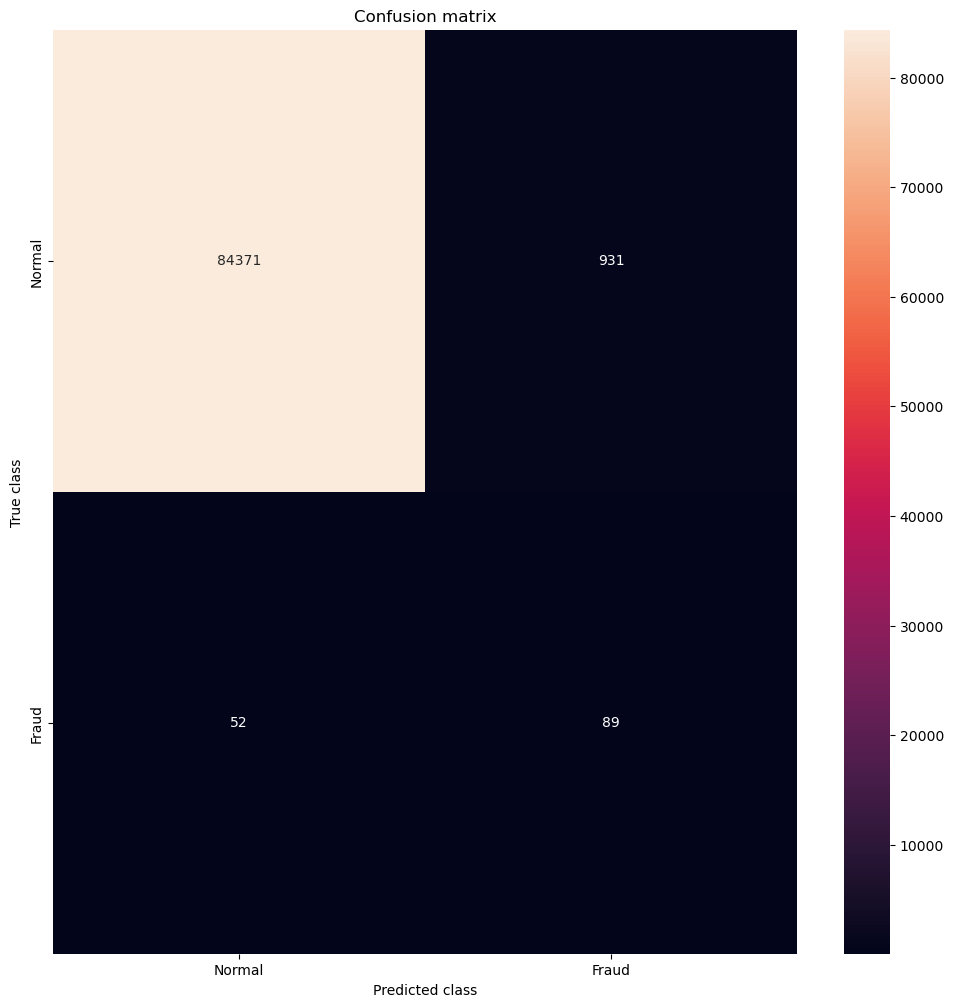

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [79]:
inp_layer = sae_L1.input
out_layer = sae_L1.layers[2].output

L1_encoder = Model(inputs=inp_layer, outputs=out_layer)

In [80]:
L1_encoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_12 (Dense)            (None, 40)                1160      
                                                                 
 dense_13 (Dense)            (None, 56)                2296      
                                                                 
Total params: 3456 (13.50 KB)
Trainable params: 3456 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
encoded_df

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,0.017938,0.170019,0.0,0.0,0.208707,0.101867,0.0,0.0,0.314729,0.146439,...,0.0,0.0,0.052944,0.0,0.0,0.097097,0.0,0.0,0.771270,0.0
1,0.149158,0.054357,0.0,0.0,0.298313,0.166524,0.0,0.0,0.467448,0.287550,...,0.0,0.0,0.191787,0.0,0.0,0.156502,0.0,0.0,0.699848,0.0
2,1.269561,0.135945,0.0,0.0,0.484714,0.203787,0.0,0.0,0.663209,0.213729,...,0.0,0.0,0.224807,0.0,0.0,0.839460,0.0,0.0,0.366746,0.0
3,0.286228,0.190642,0.0,0.0,0.175185,0.187658,0.0,0.0,0.262643,0.177828,...,0.0,0.0,0.238211,0.0,0.0,0.337822,0.0,0.0,0.497939,0.0
4,0.758039,0.125862,0.0,0.0,0.719391,0.189465,0.0,0.0,1.304156,0.505983,...,0.0,0.0,0.418211,0.0,0.0,0.933738,0.0,0.0,1.127972,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284451,0.255630,0.419930,0.0,0.0,0.165752,0.000000,0.0,0.0,0.051556,0.107127,...,0.0,0.0,0.045436,0.0,0.0,0.385368,0.0,0.0,0.031682,0.0
284452,0.034662,0.348201,0.0,0.0,0.369270,0.551272,0.0,0.0,0.246451,0.255564,...,0.0,0.0,0.000000,0.0,0.0,0.134627,0.0,0.0,0.309977,0.0
284453,0.517380,0.274140,0.0,0.0,0.361202,0.080371,0.0,0.0,0.224525,0.111706,...,0.0,0.0,0.211662,0.0,0.0,0.459796,0.0,0.0,0.168867,0.0
284454,0.664909,0.192933,0.0,0.0,0.420436,0.164637,0.0,0.0,0.000000,0.129048,...,0.0,0.0,0.129946,0.0,0.0,0.532756,0.0,0.0,0.068248,0.0


2671/2671 [==============================] - 5s 2ms/step


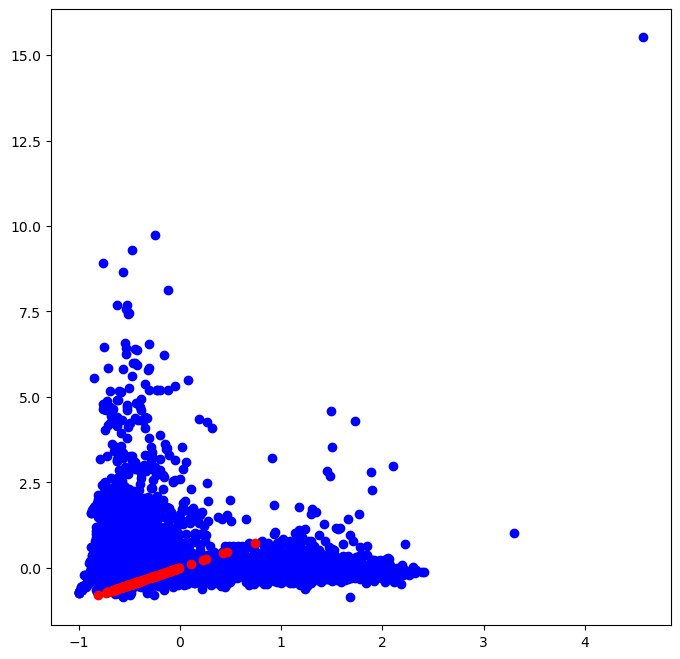

In [82]:
# hidden layer의 units가 많기 때문에 일단 0, 1번째에 대해서 latent space를 구해본다.

X_train_encoded = L1_encoder.predict(X_train)
X_test_encoded = L1_encoder.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

label = L1_encoder.layers[-1].units;

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[label]==0][0],encoded_df[encoded_df[label]==0][1], color='blue', label='Normal')
plt.scatter(encoded_df[encoded_df[label]==1][1],encoded_df[encoded_df[label]==1][1], color='red', label='Fraud');

### Sparse AutoEncoder Model(KL Reg)

In [83]:
input_dim1 = X_train.shape[1]

input_layer1 = Input(shape=(input_dim1, ))
encoder1 = Dense(40, activation="relu")(input_layer1)

encoder1 = Dense(56, activation="relu")(encoder1)

decoder1 = Dense(40, activation='relu')(encoder1)
decoder1 = Dense(input_dim1, activation='relu')(decoder1)

sae_KL = Model(inputs=input_layer1, outputs=decoder1)

#### Def sparse_regularizer

In [84]:
from keras import backend as K
from keras.losses import mse, kld


# def kl_divergence(rho, rho_hat):
#     rho_hat = K.mean(K.sigmoid(rho_hat), axis=1)
#     rho = K.constant([rho] * K.shape(rho_hat)[0])
#     return K.sum(rho * K.log(rho / rho_hat) + (1 - rho) * K.log((1 - rho) / (1 - rho_hat)))

# def sparse_loss(rho, data):
#     values = data
#     loss = 0
#     for layer in autoencoder1.layers:
#         values = layer(values)
#         loss += kl_divergence(rho, values)
#     return loss

def custom_loss(y_true, y_pred):
    mse_loss = mse(y_true, y_pred);
    sparsity = kld(y_true, y_pred);
    beta = 0.001
    
    loss = mse_loss + beta*sparsity
    return loss;

In [85]:
epochs = 100
batch_size = 32

sae_KL.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
checkpointer1 = ModelCheckpoint(filepath="fraudSpAE_KL.pth", verbose=0, save_best_only=True)

### Training

In [86]:
history1 = sae_KL.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer1]).history

Epoch 1/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.6650 - accuracy: 0.7872INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.6649 - accuracy: 0.7873 - val_loss: 0.6095 - val_accuracy: 0.8610
Epoch 2/100
5581/5598 [============================>.] - ETA: 0s - loss: 0.6141 - accuracy: 0.8901INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.6137 - accuracy: 0.8902 - val_loss: 0.5621 - val_accuracy: 0.9456
Epoch 3/100
5580/5598 [============================>.] - ETA: 0s - loss: 0.6040 - accuracy: 0.9030INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.6042 - accuracy: 0.9031 - val_loss: 0.5602 - val_accuracy: 0.9422
Epoch 4/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5869 - accuracy: 0.9340 - val_loss: 0.5648 - val_accuracy: 0.8999
Epoch 5/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.5843 - accuracy: 0.9432INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.5844 - accuracy: 0.9432 - val_loss: 0.5564 - val_accuracy: 0.9485
Epoch 6/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5867 - accuracy: 0.9401 - val_loss: 0.5632 - val_accuracy: 0.9296
Epoch 7/100
5585/5598 [============================>.] - ETA: 0s - loss: 0.5906 - accuracy: 0.9264INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.5904 - accuracy: 0.9265 - val_loss: 0.5544 - val_accuracy: 0.9682
Epoch 8/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5975 - accuracy: 0.9135 - val_loss: 0.5705 - val_accuracy: 0.8832
Epoch 9/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5834 - accuracy: 0.9471 - val_loss: 0.5553 - val_accuracy: 0.9558
Epoch 10/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5861 - accuracy: 0.9393 - val_loss: 0.5726 - val_accuracy: 0.8890
Epoch 11/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.5973 - accuracy: 0.9276 - val_loss: 0.5579 - val_accuracy: 0.9572
Epoch 12/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5863 - accuracy: 0.9455 - val_loss: 0.5550 - val_accuracy: 0.9656
Epoch 13/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5819 - accuracy: 0.9556 - val_loss: 0.5605 - val_acc

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.5870 - accuracy: 0.9539 - val_loss: 0.5541 - val_accuracy: 0.9738
Epoch 34/100
5586/5598 [============================>.] - ETA: 0s - loss: 0.5802 - accuracy: 0.9653INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 0.5800 - accuracy: 0.9653 - val_loss: 0.5539 - val_accuracy: 0.9706
Epoch 35/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5818 - accuracy: 0.9552 - val_loss: 0.5668 - val_accuracy: 0.9598
Epoch 36/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5806 - accuracy: 0.9631 - val_loss: 0.5539 - val_accuracy: 0.9682
Epoch 37/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5808 - accuracy: 0.9632 - val_loss: 0.5644 - val_accuracy: 0.9142
Epoch 38/100
5581/5598 [============================>.] - ETA: 0s - loss: 0.5816 - accuracy: 0.9584INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.5815 - accuracy: 0.9585 - val_loss: 0.5538 - val_accuracy: 0.9740
Epoch 39/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5882 - accuracy: 0.9396 - val_loss: 0.5556 - val_accuracy: 0.9577
Epoch 40/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5812 - accuracy: 0.9637 - val_loss: 0.5550 - val_accuracy: 0.9639
Epoch 41/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.5815 - accuracy: 0.9589INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.5815 - accuracy: 0.9589 - val_loss: 0.5535 - val_accuracy: 0.9788
Epoch 42/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5905 - accuracy: 0.9311 - val_loss: 0.5654 - val_accuracy: 0.9321
Epoch 43/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5946 - accuracy: 0.9130 - val_loss: 0.5557 - val_accuracy: 0.9342
Epoch 44/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5807 - accuracy: 0.9619 - val_loss: 0.5537 - val_accuracy: 0.9770
Epoch 45/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5833 - accuracy: 0.9535 - val_loss: 0.5542 - val_accuracy: 0.9701
Epoch 46/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5824 - accuracy: 0.9533 - val_loss: 0.5543 - val_accuracy: 0.9627
Epoch 47/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.5817 - accuracy: 0.9595 - val_loss: 0.5555 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.5798 - accuracy: 0.9686 - val_loss: 0.5534 - val_accuracy: 0.9810
Epoch 59/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5818 - accuracy: 0.9628 - val_loss: 0.5548 - val_accuracy: 0.9693
Epoch 60/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5868 - accuracy: 0.9443 - val_loss: 0.5550 - val_accuracy: 0.9487
Epoch 61/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.5822 - accuracy: 0.9583 - val_loss: 0.5546 - val_accuracy: 0.9521
Epoch 62/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5820 - accuracy: 0.9580 - val_loss: 0.5568 - val_accuracy: 0.9483
Epoch 63/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5830 - accuracy: 0.9503 - val_loss: 0.5545 - val_accuracy: 0.9650
Epoch 64/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5817 - accuracy: 0.9601 - val_loss: 0.5537 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 16s 3ms/step - loss: 0.5796 - accuracy: 0.9696 - val_loss: 0.5533 - val_accuracy: 0.9865
Epoch 80/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5803 - accuracy: 0.9645 - val_loss: 0.5540 - val_accuracy: 0.9804
Epoch 81/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5813 - accuracy: 0.9606 - val_loss: 0.5535 - val_accuracy: 0.9769
Epoch 82/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5815 - accuracy: 0.9623 - val_loss: 0.5540 - val_accuracy: 0.9644
Epoch 83/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5848 - accuracy: 0.9517 - val_loss: 0.5562 - val_accuracy: 0.9485
Epoch 84/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5810 - accuracy: 0.9568 - val_loss: 0.5535 - val_accuracy: 0.9813
Epoch 85/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.5806 - accuracy: 0.9650 - val_loss: 0.5595 - val_a

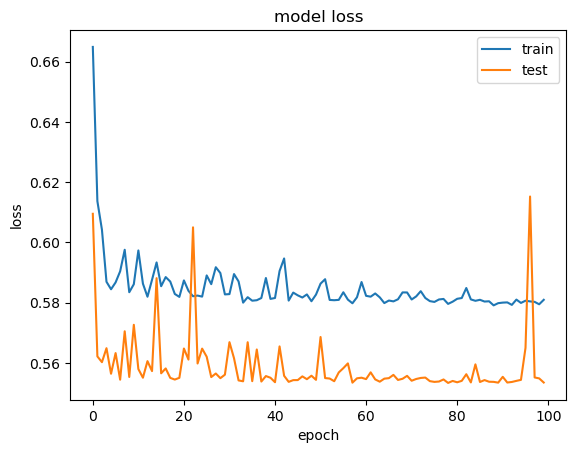

In [87]:
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [88]:
with keras.utils.custom_object_scope({"custom_loss": 'mse'}):
    sae_KL = keras.models.load_model('fraudSpAE_KL.pth')

In [89]:
KL_encode = sae_KL.predict(X_test)
mse1 = np.mean(np.power(X_test - KL_encode, 2), axis=1)
error_df1 = pd.DataFrame({'reconstruction_error': mse1,
                        'true_class': y_test})
error_df1.describe()

2671/2671 [==============================] - 4s 2ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.603888,0.00165
std,3.362722,0.04059
min,0.017287,0.00000
25%,0.170935,0.00000
50%,0.293653,0.00000
75%,0.496699,0.00000
max,392.828118,1.00000


In [90]:
threshold1 = 2.9

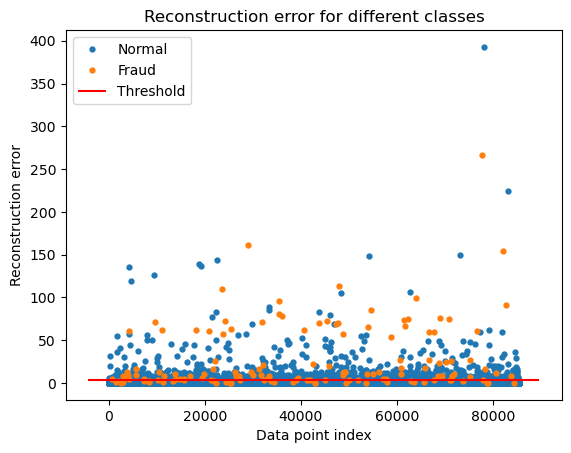

In [91]:
groups = error_df1.groupby('true_class')
fig1, ax1 = plt.subplots()

for name, group in groups:
    ax1.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax1.hlines(threshold1, ax1.get_xlim()[0], ax1.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax1.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

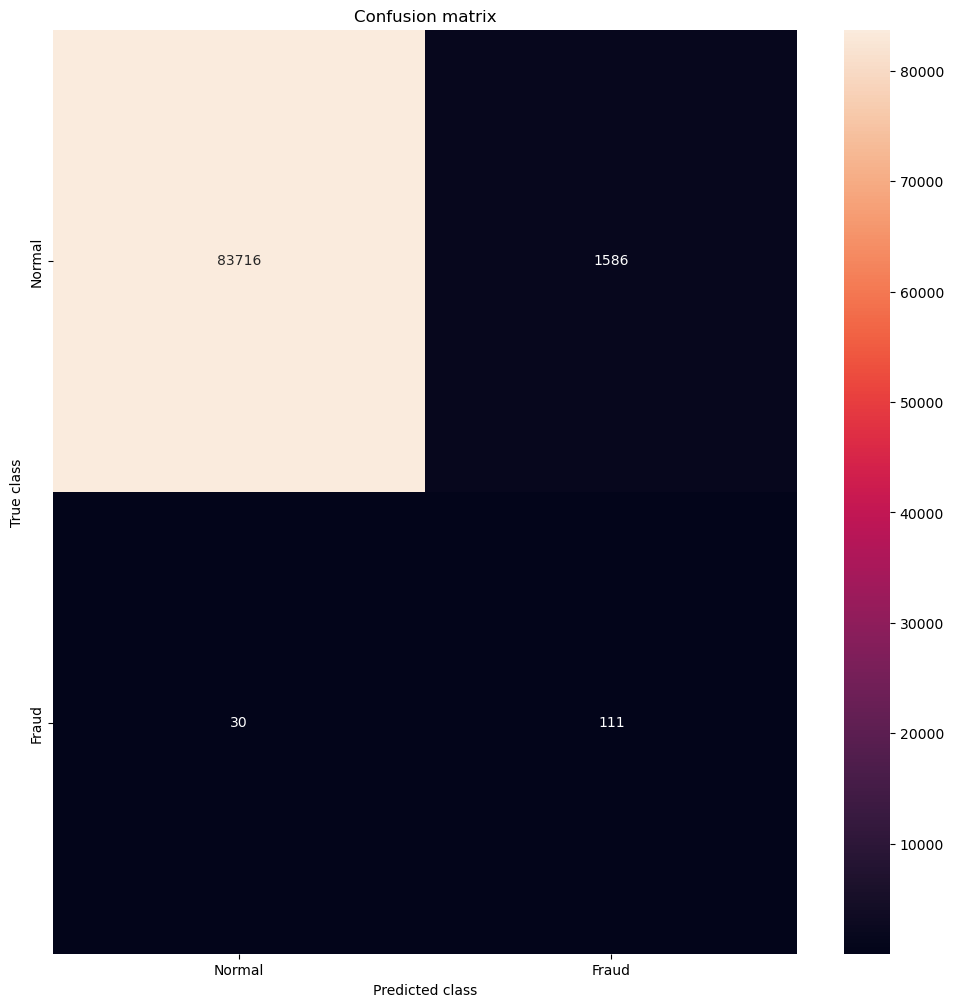

In [92]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred1 = [1 if e > threshold1 else 0 for e in error_df1.reconstruction_error.values]
conf_matrix1 = confusion_matrix(error_df1.true_class, y_pred1)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix1, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [94]:
inp_layer1 = sae_KL.input
out_layer1 = sae_KL.layers[2].output

KL_encoder = Model(inputs=inp_layer1, outputs=out_layer1)

In [95]:
KL_encoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_16 (Dense)            (None, 40)                1160      
                                                                 
 dense_17 (Dense)            (None, 56)                2296      
                                                                 
Total params: 3456 (13.50 KB)
Trainable params: 3456 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2671/2671 [==============================] - 4s 2ms/step


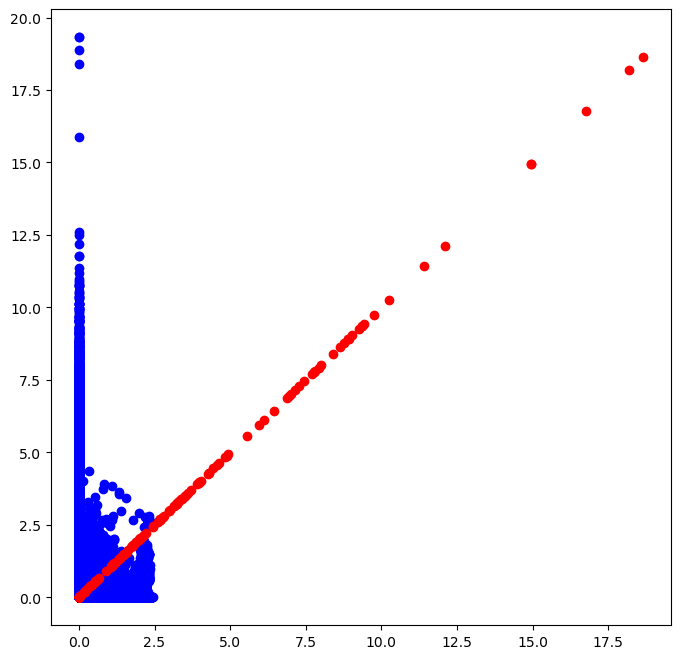

In [98]:
X_train_encoded = sae_KL.predict(X_train)
X_test_encoded = sae_KL.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

label = 28;

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[label]==0][0],encoded_df[encoded_df[label]==0][1], color='blue', label='Normal')
plt.scatter(encoded_df[encoded_df[label]==1][1],encoded_df[encoded_df[label]==1][1], color='red', label='Fraud');